In [1]:
import os 
os.getcwd()
os.chdir("/users/eleves-a/2025/youssef.sidhom/Object_detection_in_documents")

In [2]:
from wrapper.Qwen_25_LLM import Qwen_llm

BASE_MODEL_PATH = "Qwen/Qwen2.5-VL-3B-Instruct"

# The directory where SFTTrainer saved your fine-tuned adapter
ADAPTER_PATH = "./qwen2.5-vl-signature-detector"

model=Qwen_llm(base_model_path=BASE_MODEL_PATH, adapter_path=ADAPTER_PATH)
model.load()

/users/eleves-a/2025/youssef.sidhom/Object_detection_in_documents/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!


⏳ Loading Base Model from Qwen/Qwen2.5-VL-3B-Instruct...


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


⏳ Merging LoRA Adapter from ./qwen2.5-vl-signature-detector...
🛡️ Model loaded in EVALUATION (Inference) mode.
⏳ Loading Processor...
✅ Model and Processor loaded successfully.


In [2]:
TEST_IMAGE_PATH = "./data/images/test_oib30f00-first-var_jpg.rf.8230feb7ec08f9ffe2de7a813f7fcaff_orig.jpg"
output_text=model.predict(TEST_IMAGE_PATH,"Locate the signature")
output_text=model.postprocess(output_text,image_width=640,image_height=640)
ground_truth="<|box_start|>(520,264),(683,328)<|box_end|> signature"
ground_truth=model.postprocess(ground_truth,image_width=640,image_height=640)
print("Output:",output_text)
print("Ground Truth:",ground_truth)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Output: [[166, 328, 210, 440]]
Ground Truth: [[168, 332, 209, 437]]


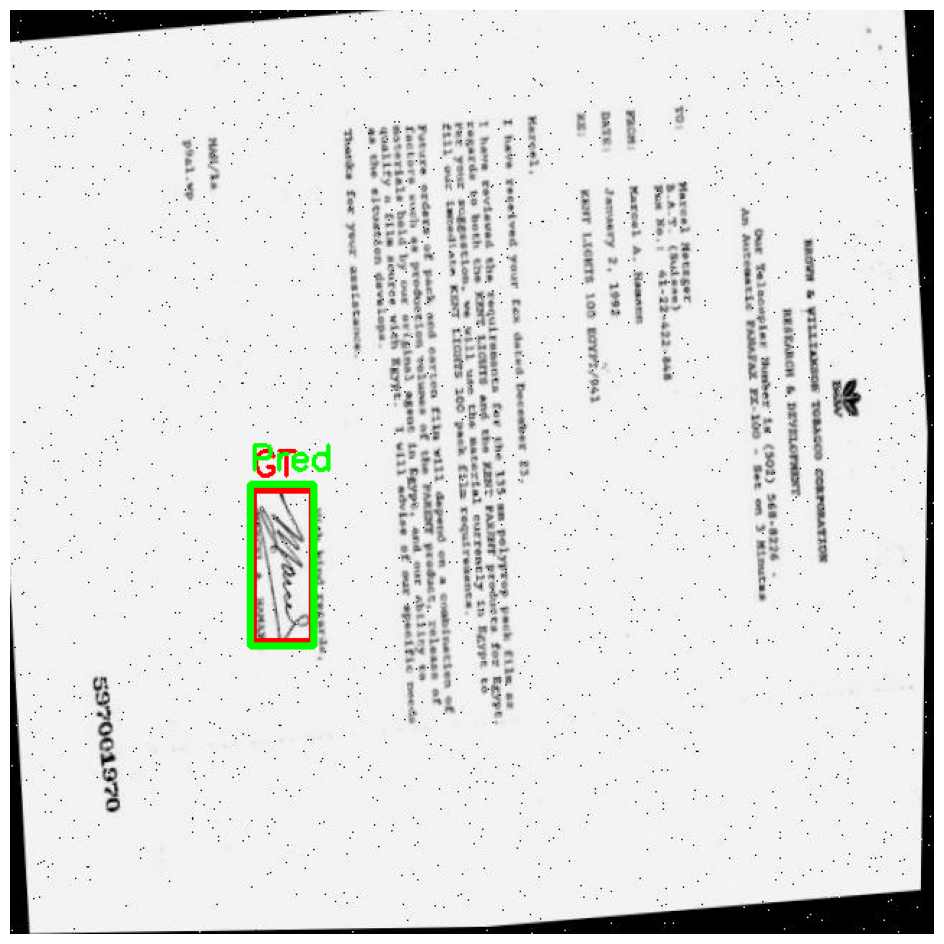

In [3]:
model.plot_bounding_box_and_ground_truth(TEST_IMAGE_PATH,output_text,ground_truth)

## Metrics

### Metrics used to evalute performance
- Hard evaluation metrics: 
    - IoU: The standard academic benchmark.
- Soft evaluation metrics:
    - Iop: Intersection over prediction, how much of your predicted box is inside the ground Truth
    - Center-point hit: if the center of the predicted box is inside the center 
    - Center distance error: The distance between the center of the predicted box and the center of the ground truth

In [4]:
import math

def evaluate_detection(pred_box, gt_box, img_width=1, img_height=1):
    """
    Evaluates prediction against ground truth with distance metrics.
    
    Args:
        pred_box (list): [xmin, ymin, xmax, ymax]
        gt_box (list):   [xmin, ymin, xmax, ymax]
        img_width (int): Width of the image (for normalization)
        img_height (int): Height of the image (for normalization)
        
    Returns:
        dict: IoU, IoP, Center Distance (Pixels), Normalized Center Distance (0-1)
    """
    # --- 1. IoU Calculation (Standard) ---
    xA = max(pred_box[0], gt_box[0])
    yA = max(pred_box[1], gt_box[1])
    xB = min(pred_box[2], gt_box[2])
    yB = min(pred_box[3], gt_box[3])
    
    interArea = max(0, xB - xA) * max(0, yB - yA)
    predArea = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gtArea = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    
    iou = interArea / float(predArea + gtArea - interArea + 1e-6)
    iop = interArea / float(predArea + 1e-6) # Intersection over Prediction

    # --- 2. Center Point Calculation ---
    pred_cx = (pred_box[0] + pred_box[2]) / 2.0
    pred_cy = (pred_box[1] + pred_box[3]) / 2.0
    
    gt_cx = (gt_box[0] + gt_box[2]) / 2.0
    gt_cy = (gt_box[1] + gt_box[3]) / 2.0
    
    # --- 3. Euclidean Distance (Pixels) ---
    # Pythagorean theorem: a^2 + b^2 = c^2
    dist_pixels = math.sqrt((pred_cx - gt_cx)**2 + (pred_cy - gt_cy)**2)
    
    # --- 4. Normalized Distance (0.0 to 1.0) ---
    # Distance relative to the image diagonal. 
    # 0.05 means the center is off by 5% of the image size.
    # This helps compare errors across images of different resolutions.
    img_diagonal = math.sqrt(img_width**2 + img_height**2) + 1e-6
    norm_dist = dist_pixels / img_diagonal

    return {
        "iou": round(iou, 4),
        "iop": round(iop, 4),
        "center_dist_px": round(dist_pixels, 1),
        "norm_center_dist": round(norm_dist, 4)
    }

### Load test images and ground_truth

In [5]:
import numpy as np

def calculate_iou(boxA, boxB):
    # Standard IoU calculation
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

def match_predictions_to_ground_truth(pred_boxes, gt_boxes, iou_threshold=0.5):
    """
    Matches predictions to ground truths using greedy IoU strategy.
    
    Args:
        pred_boxes (list): List of [xmin, ymin, xmax, ymax]
        gt_boxes (list):   List of [xmin, ymin, xmax, ymax]
        iou_threshold (float): Minimum IoU to consider a match valid
        
    Returns:
        matches (list): List of dicts {'pred': box, 'gt': box, 'iou': float}
        unmatched_preds (list): List of pred_boxes that matched nothing
        unmatched_gts (list): List of gt_boxes that were missed
    """
    matches = []
    # pred_boxes = [box['bbox_2d'] for box in pred_boxes]
    
    # Keep track of which indices have been matched
    matched_pred_indices = set()
    matched_gt_indices = set()
    
    # 1. Calculate IoU for ALL pairs
    # Format: (iou, pred_index, gt_index)
    all_pairs = []
    for i, p_box in enumerate(pred_boxes):
        for j, g_box in enumerate(gt_boxes):
            iou = calculate_iou(p_box, g_box)
            if iou > 0.0: # Only consider pairs that overlap at least a little
                all_pairs.append((iou, i, j))
    
    # 2. Sort pairs by IoU (Highest first)
    all_pairs.sort(key=lambda x: x[0], reverse=True)
    
    # 3. Greedy Matching
    for iou, p_idx, g_idx in all_pairs:
        if p_idx not in matched_pred_indices and g_idx not in matched_gt_indices:
            # Found the best remaining match!
            if iou >= iou_threshold:
                matches.append({
                    'pred': pred_boxes[p_idx],
                    'gt': gt_boxes[g_idx],
                    'iou': iou
                })
                matched_pred_indices.add(p_idx)
                matched_gt_indices.add(g_idx)
    
    # 4. Gather leftovers
    unmatched_preds = [p for i, p in enumerate(pred_boxes) if i not in matched_pred_indices]
    unmatched_gts = [g for i, g in enumerate(gt_boxes) if i not in matched_gt_indices]
    
    return matches, unmatched_preds, unmatched_gts

## test metrics on one single image 

In [3]:
#load data: 

import json

test_json_path = 'data/test.jsonl'
test_json = []

with open(test_json_path, 'r', encoding='utf-8') as f:
    for line in f:
        json_data = json.loads(line)
        image_path=json_data['messages'][0]['content'][0]['image']
        ground_truth=json_data['messages'][1]['content'][0]['text']
        test_json.append({
                        'image_path': image_path,
                        'groundTruth': ground_truth
                        })

# Now test_json is a list of dictionaries
print(test_json)

[{'image_path': '/users/eleves-a/2025/youssef.sidhom/Object_detection_in_documents/data/images/test_oib30f00-first-var_jpg.rf.8230feb7ec08f9ffe2de7a813f7fcaff_orig.jpg', 'groundTruth': '<|box_start|>(520,264),(683,328)<|box_end|> signature'}, {'image_path': '/users/eleves-a/2025/youssef.sidhom/Object_detection_in_documents/data/images/test_image_144_png_jpg.rf.97b82e017b6f15bc9167703a6441d825_orig.jpg', 'groundTruth': '<|box_start|>(7,693),(374,852)<|box_end|> signature'}, {'image_path': '/users/eleves-a/2025/youssef.sidhom/Object_detection_in_documents/data/images/test_boa85f00_jpg.rf.eb0bd16aa6f554ad52515272fc06b617_orig.jpg', 'groundTruth': '<|box_start|>(445,200),(493,386)<|box_end|> signature'}, {'image_path': '/users/eleves-a/2025/youssef.sidhom/Object_detection_in_documents/data/images/test_duz52d00-page02-var_3_jpg.rf.1ee6fc30cb4c1d7aee4fbd8cc367fb40_orig.jpg', 'groundTruth': '<|box_start|>(406,185),(481,262)<|box_end|> signature'}, {'image_path': '/users/eleves-a/2025/youssef.

In [6]:
type(test_json)

list

### model perf after (1+3)=4 epochs

In [16]:
from tqdm import tqdm
metrics_summary = {
    "iou": [],
    "iop": [],
    "norm_dist": [],
    "false_positives": 0,
    "missed_signatures": 0,
    "total_images": 0
}

for item in tqdm(test_json):
    image_path = item['image_path']
    ground_truth = item['groundTruth']
    
    metrics_summary["total_images"] += 1

    
    output_text = model.predict(image_path, "Locate the signature")
    output_text = model.postprocess(output_text, image_width=640, image_height=640)
    ground_truth = model.postprocess(ground_truth, image_width=640, image_height=640)
    
    matches, false_positives, misses = match_predictions_to_ground_truth(output_text, ground_truth, iou_threshold=0.1)
    metrics_summary["false_positives"] += len(false_positives)
    metrics_summary["missed_signatures"] += len(misses)

    
    # Collect Metrics for Matches
    for match in matches:
        # Evaluate using the normalized distance metric
        m = evaluate_detection(match['pred'], match['gt'], img_width=640, img_height=640)
        
        metrics_summary["iou"].append(m['iou'])
        metrics_summary["iop"].append(m['iop'])
        metrics_summary["norm_dist"].append(m['norm_center_dist'])
    
# --- 3. Calculate Averages ---
total_matches = len(metrics_summary["iou"])

if total_matches > 0:
    avg_iou = sum(metrics_summary["iou"]) / total_matches
    avg_iop = sum(metrics_summary["iop"]) / total_matches
    avg_norm_dist = sum(metrics_summary["norm_dist"]) / total_matches
else:
    avg_iou = avg_iop = avg_norm_dist = 0.0

# --- 4. Final Report ---
print("\n" + "="*50)
print(f" FINAL EVALUATION REPORT ({metrics_summary['total_images']} Images)")
print("="*50)
print(f"Total Matches Found:      {total_matches}")
print(f"Total Missed Signatures:  {metrics_summary['missed_signatures']}")
print(f"Total False Positives:    {metrics_summary['false_positives']}")
print("-" * 50)
print(f"Mean IoU (Overlap):             {avg_iou:.4f}")
print(f"Mean IoP (Tightness/Precision): {avg_iop:.4f}")
print(f"Mean Normalized Center Error:   {avg_norm_dist:.4f} ({(avg_norm_dist*100):.2f}% of image diagonal)")
print("="*50)

  0%|          | 0/257 [00:00<?, ?it/s]

100%|██████████| 257/257 [03:44<00:00,  1.14it/s]


 FINAL EVALUATION REPORT (257 Images)
Total Matches Found:      249
Total Missed Signatures:  71
Total False Positives:    25
--------------------------------------------------
Mean IoU (Overlap):             0.5386
Mean IoP (Tightness/Precision): 0.6889
Mean Normalized Center Error:   0.0211 (2.11% of image diagonal)


### model perf after (1+3+3)=7 epochs

In [7]:
from tqdm import tqdm
metrics_summary = {
    "iou": [],
    "iop": [],
    "norm_dist": [],
    "false_positives": 0,
    "missed_signatures": 0,
    "total_images": 0
}

for item in tqdm(test_json):
    image_path = item['image_path']
    ground_truth = item['groundTruth']
    
    metrics_summary["total_images"] += 1

    
    output_text = model.predict(image_path, "Locate the signature")
    output_text = model.postprocess(output_text, image_width=640, image_height=640)
    ground_truth = model.postprocess(ground_truth, image_width=640, image_height=640)
    
    matches, false_positives, misses = match_predictions_to_ground_truth(output_text, ground_truth, iou_threshold=0.1)
    metrics_summary["false_positives"] += len(false_positives)
    metrics_summary["missed_signatures"] += len(misses)

    
    # Collect Metrics for Matches
    for match in matches:
        # Evaluate using the normalized distance metric
        m = evaluate_detection(match['pred'], match['gt'], img_width=640, img_height=640)
        
        metrics_summary["iou"].append(m['iou'])
        metrics_summary["iop"].append(m['iop'])
        metrics_summary["norm_dist"].append(m['norm_center_dist'])
    
# --- 3. Calculate Averages ---
total_matches = len(metrics_summary["iou"])

if total_matches > 0:
    avg_iou = sum(metrics_summary["iou"]) / total_matches
    avg_iop = sum(metrics_summary["iop"]) / total_matches
    avg_norm_dist = sum(metrics_summary["norm_dist"]) / total_matches
else:
    avg_iou = avg_iop = avg_norm_dist = 0.0

# --- 4. Final Report ---
print("\n" + "="*50)
print(f" FINAL EVALUATION REPORT ({metrics_summary['total_images']} Images)")
print("="*50)
print(f"Total Matches Found:      {total_matches}")
print(f"Total Missed Signatures:  {metrics_summary['missed_signatures']}")
print(f"Total False Positives:    {metrics_summary['false_positives']}")
print("-" * 50)
print(f"Mean IoU (Overlap):             {avg_iou:.4f}")
print(f"Mean IoP (Tightness/Precision): {avg_iop:.4f}")
print(f"Mean Normalized Center Error:   {avg_norm_dist:.4f} ({(avg_norm_dist*100):.2f}% of image diagonal)")
print("="*50)

100%|██████████| 257/257 [04:06<00:00,  1.04it/s]


 FINAL EVALUATION REPORT (257 Images)
Total Matches Found:      302
Total Missed Signatures:  18
Total False Positives:    9
--------------------------------------------------
Mean IoU (Overlap):             0.7796
Mean IoP (Tightness/Precision): 0.8752
Mean Normalized Center Error:   0.0076 (0.76% of image diagonal)


Epoch 3 and 16r on lora

In [7]:
from tqdm import tqdm
metrics_summary = {
    "iou": [],
    "iop": [],
    "norm_dist": [],
    "false_positives": 0,
    "missed_signatures": 0,
    "total_images": 0
}

for item in tqdm(test_json):
    image_path = item['image_path']
    ground_truth = item['groundTruth']
    
    metrics_summary["total_images"] += 1

    
    output_text = model.predict(image_path, "Locate the signature")
    output_text = model.postprocess(output_text, image_width=640, image_height=640)
    ground_truth = model.postprocess(ground_truth, image_width=640, image_height=640)
    
    matches, false_positives, misses = match_predictions_to_ground_truth(output_text, ground_truth, iou_threshold=0.1)
    metrics_summary["false_positives"] += len(false_positives)
    metrics_summary["missed_signatures"] += len(misses)

    
    # Collect Metrics for Matches
    for match in matches:
        # Evaluate using the normalized distance metric
        m = evaluate_detection(match['pred'], match['gt'], img_width=640, img_height=640)
        
        metrics_summary["iou"].append(m['iou'])
        metrics_summary["iop"].append(m['iop'])
        metrics_summary["norm_dist"].append(m['norm_center_dist'])
    
# --- 3. Calculate Averages ---
total_matches = len(metrics_summary["iou"])

if total_matches > 0:
    avg_iou = sum(metrics_summary["iou"]) / total_matches
    avg_iop = sum(metrics_summary["iop"]) / total_matches
    avg_norm_dist = sum(metrics_summary["norm_dist"]) / total_matches
else:
    avg_iou = avg_iop = avg_norm_dist = 0.0

# --- 4. Final Report ---
print("\n" + "="*50)
print(f" FINAL EVALUATION REPORT ({metrics_summary['total_images']} Images)")
print("="*50)
print(f"Total Matches Found:      {total_matches}")
print(f"Total Missed Signatures:  {metrics_summary['missed_signatures']}")
print(f"Total False Positives:    {metrics_summary['false_positives']}")
print("-" * 50)
print(f"Mean IoU (Overlap):             {avg_iou:.4f}")
print(f"Mean IoP (Tightness/Precision): {avg_iop:.4f}")
print(f"Mean Normalized Center Error:   {avg_norm_dist:.4f} ({(avg_norm_dist*100):.2f}% of image diagonal)")
print("="*50)

100%|██████████| 257/257 [04:08<00:00,  1.04it/s]


 FINAL EVALUATION REPORT (257 Images)
Total Matches Found:      298
Total Missed Signatures:  22
Total False Positives:    13
--------------------------------------------------
Mean IoU (Overlap):             0.6988
Mean IoP (Tightness/Precision): 0.8269
Mean Normalized Center Error:   0.0115 (1.15% of image diagonal)


Epoch 10 and 16r on lora

In [7]:
from tqdm import tqdm
metrics_summary = {
    "iou": [],
    "iop": [],
    "norm_dist": [],
    "false_positives": 0,
    "missed_signatures": 0,
    "total_images": 0
}

for item in tqdm(test_json):
    image_path = item['image_path']
    ground_truth = item['groundTruth']
    
    metrics_summary["total_images"] += 1

    
    output_text = model.predict(image_path, "Locate the signature")
    output_text = model.postprocess(output_text, image_width=640, image_height=640)
    ground_truth = model.postprocess(ground_truth, image_width=640, image_height=640)
    
    matches, false_positives, misses = match_predictions_to_ground_truth(output_text, ground_truth, iou_threshold=0.1)
    metrics_summary["false_positives"] += len(false_positives)
    metrics_summary["missed_signatures"] += len(misses)

    
    # Collect Metrics for Matches
    for match in matches:
        # Evaluate using the normalized distance metric
        m = evaluate_detection(match['pred'], match['gt'], img_width=640, img_height=640)
        
        metrics_summary["iou"].append(m['iou'])
        metrics_summary["iop"].append(m['iop'])
        metrics_summary["norm_dist"].append(m['norm_center_dist'])
    
# --- 3. Calculate Averages ---
total_matches = len(metrics_summary["iou"])

if total_matches > 0:
    avg_iou = sum(metrics_summary["iou"]) / total_matches
    avg_iop = sum(metrics_summary["iop"]) / total_matches
    avg_norm_dist = sum(metrics_summary["norm_dist"]) / total_matches
else:
    avg_iou = avg_iop = avg_norm_dist = 0.0

# --- 4. Final Report ---
print("\n" + "="*50)
print(f" FINAL EVALUATION REPORT ({metrics_summary['total_images']} Images)")
print("="*50)
print(f"Total Matches Found:      {total_matches}")
print(f"Total Missed Signatures:  {metrics_summary['missed_signatures']}")
print(f"Total False Positives:    {metrics_summary['false_positives']}")
print("-" * 50)
print(f"Mean IoU (Overlap):             {avg_iou:.4f}")
print(f"Mean IoP (Tightness/Precision): {avg_iop:.4f}")
print(f"Mean Normalized Center Error:   {avg_norm_dist:.4f} ({(avg_norm_dist*100):.2f}% of image diagonal)")
print("="*50)

100%|██████████| 257/257 [04:11<00:00,  1.02it/s]


 FINAL EVALUATION REPORT (257 Images)
Total Matches Found:      294
Total Missed Signatures:  26
Total False Positives:    20
--------------------------------------------------
Mean IoU (Overlap):             0.7696
Mean IoP (Tightness/Precision): 0.8588
Mean Normalized Center Error:   0.0085 (0.85% of image diagonal)


In [4]:
model.evaluate(test_json)

100%|██████████| 257/257 [04:11<00:00,  1.02it/s]


 FINAL EVALUATION REPORT (257 Images)
Total Matches Found:      294
Total Missed Signatures:  26
Total False Positives:    20
--------------------------------------------------
Mean IoU (Overlap):             0.7696
Mean IoP (Tightness/Precision): 0.8588
Mean Normalized Center Error:   0.0085 (0.85% of image diagonal)
📁 Saved conflicting predictions to conflicting_predictions.json for error analysis.


{'iou': [0.8736,
  0.9221,
  0.7452,
  0.8228,
  0.8686,
  0.8823,
  0.6469,
  0.415,
  0.2764,
  0.8789,
  0.9282,
  0.904,
  0.8702,
  0.8171,
  0.7305,
  0.6697,
  0.8964,
  0.6978,
  0.738,
  0.7769,
  0.7602,
  0.4094,
  0.1332,
  0.7364,
  0.3906,
  0.8958,
  0.8579,
  0.7674,
  0.8182,
  0.378,
  0.8651,
  0.9417,
  0.7958,
  0.8535,
  0.9474,
  0.8506,
  0.8473,
  0.7298,
  0.6662,
  0.8685,
  0.7728,
  0.6824,
  0.8705,
  0.5787,
  0.6853,
  0.4266,
  0.9136,
  0.8089,
  0.8959,
  0.9405,
  0.7479,
  0.8767,
  0.71,
  0.9048,
  0.8204,
  0.767,
  0.1425,
  0.81,
  0.8011,
  0.1325,
  0.8041,
  0.7682,
  0.8958,
  0.7196,
  0.3576,
  0.9046,
  0.4469,
  0.4141,
  0.8123,
  0.6417,
  0.9866,
  0.8684,
  0.7995,
  0.8368,
  0.7119,
  0.5037,
  0.8099,
  0.8861,
  0.712,
  0.757,
  0.9924,
  0.8934,
  0.8216,
  0.803,
  0.9463,
  0.8284,
  0.8015,
  0.6338,
  0.7806,
  0.8249,
  0.8576,
  0.8739,
  0.8053,
  0.8479,
  0.727,
  0.8983,
  0.8824,
  0.6768,
  0.843,
  0.8324,
  0.892

Analysis of conflicts

In [19]:
#load data: 

import json

test_json_path = 'conflicting_predictions.json'
test_json = json.load(open(test_json_path, 'r', encoding='utf-8'))
import math
import os
import matplotlib.pyplot as plt
import cv2
def plot_multiple_bounding_boxes(data_list, cols=2, save_path=None):
    """
    Plots multiple images with predictions and ground truths on a single grid figure.
    
    Args:
        data_list (list): List of dictionaries, each containing:
            - 'image_path' (str): Path to the image.
            - 'predictions' (list): List of predicted bounding boxes [x1, y1, x2, y2].
            - 'ground_truths' (list, optional): List of ground truth bounding boxes.
        cols (int): Number of columns in the subplot grid.
        save_path (str, optional): Path to save the final grid image.
    """
    n = len(data_list)
    if n == 0:
        print("❌ Error: No data provided to plot.")
        return

    # Calculate required rows based on number of items and columns
    rows = math.ceil(n / cols)
    
    # Initialize the figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))
    
    # Flatten the axes array to easily iterate over it regardless of grid shape
    if n == 1 or (rows == 1 and cols == 1):
        axes = [axes]
    elif hasattr(axes, 'flatten'):
        axes = axes.flatten()
        
    for i, data in enumerate(data_list):
        ax = axes[i]
        image_path = data.get("image_path")
        predictions = data.get("predictions", [])
        ground_truths = data.get("ground_truths", [])
        
        image = cv2.imread(image_path)
        if image is None:
            print(f"❌ Error: Could not load image at {image_path}")
            ax.axis("off")
            continue
            
        # OpenCV loads images in BGR format, so we convert to RGB for Matplotlib
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Plot Ground Truths (RED)
        if ground_truths:
            for gt_box in ground_truths:
                x1, y1, x2, y2 = map(int, gt_box)
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 3)
                cv2.putText(image, "GT", (x1, max(y1 - 10, 10)), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

        # Plot Predictions (GREEN)
        for pred_box in predictions:
            x1, y1, x2, y2 = map(int, pred_box)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 3)
            cv2.putText(image, "Pred", (x1, max(y1 - 10, 10)), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        # Display the processed image on the specific subplot axis
        ax.imshow(image)
        ax.axis("off") # Hide the axis labels
        ax.set_title(os.path.basename(image_path), fontsize=12)

    # Hide any unused subplots if the grid has empty cells at the end
    for j in range(len(data_list), len(axes)):
        axes[j].axis("off")
        axes[j].set_visible(False)

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"📸 Saved visualization grid to {save_path}")
    else:
        plt.show()

📸 Saved visualization grid to evaluation_grid.png


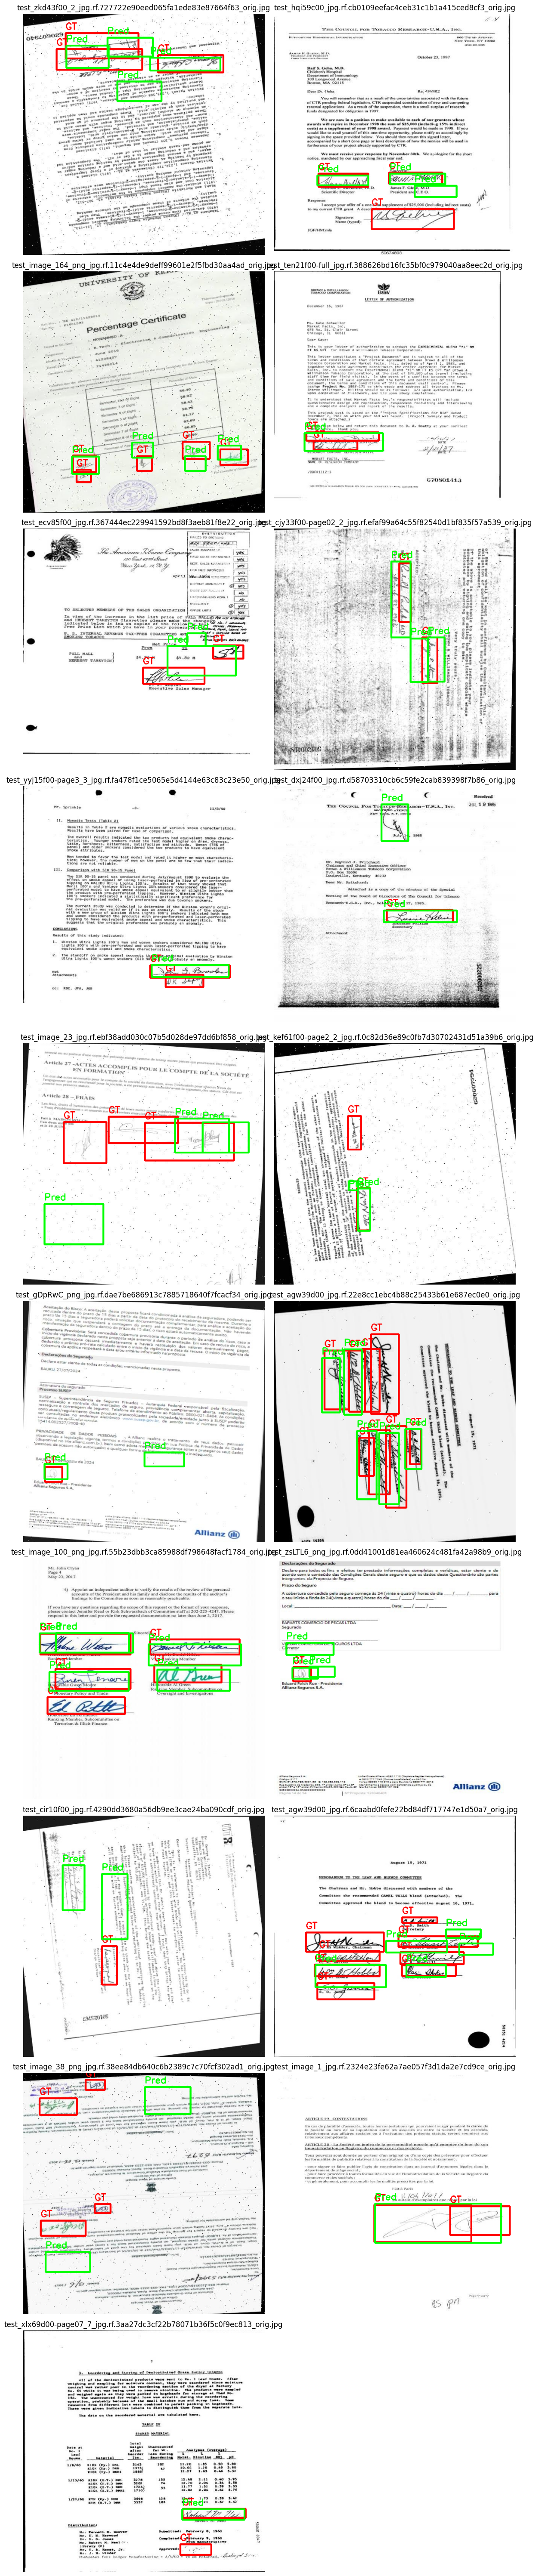

In [20]:
plot_multiple_bounding_boxes(test_json, cols=2, save_path="evaluation_grid.png")